In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline.balphagore import Balphagore

2021-11-01 02:32:47.392351: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-01 02:32:47.392629: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [259]:
def reco_mysql():
    from django.db import connections, connection
    for conn in connections.all():
        conn.close_if_unusable_or_obsolete()

In [398]:
balphagore = Balphagore()
balphagore.load_dataset(filters={'start_at__date__gte':'2019-01-01', 'start_at__date__lte':'2019-12-31', 'sub_category__in': ['AUTOSTART', 'NATIONALE']})

2020 races


In [491]:
balphagore.df['target'] = ((balphagore.df['position'] >= 1) & (balphagore.df['position'] <= balphagore.df['declared_player_count'] / 3)).astype('float')
balphagore.TARGET = 'target'
balphagore.FEATURES = balphagore.FEATURES + ['final_odds_ref', 'final_odds']

In [492]:
balphagore.train()

20350 train samples, 4981 validation samples


Epoch 1/10
299/299 [==============================] - 2s 3ms/step - loss: 2.9208
Epoch 2/10
299/299 [==============================] - 1s 3ms/step - loss: 2.1344
Epoch 3/10
299/299 [==============================] - 1s 3ms/step - loss: 1.4340
Epoch 4/10
299/299 [==============================] - 1s 3ms/step - loss: 0.7711
Epoch 5/10
299/299 [==============================] - 1s 3ms/step - loss: 0.6389
Epoch 6/10
299/299 [==============================] - 1s 4ms/step - loss: 0.5984
Epoch 7/10
299/299 [==============================] - 1s 4ms/step - loss: 0.5855
Epoch 8/10
299/299 [==============================] - 1s 4ms/step - loss: 0.5738
Epoch 9/10
299/299 [==============================] - 1s 3ms/step - loss: 0.6091
Epoch 10/10
318/318 [==============================] - 1s 2ms/step
Epoch 1/10
300/300 [==============================] - 2s 4ms/step - loss: 2.0329
Epoch 2/10
300/300 [==============================] - 1s 4ms/step - loss: 0.6776
Epoch 3/10
300/300 [======================

In [494]:
balphagore.debug_race(balphagore.df_train)

position sub_category  num                     music  \
race_id                                                               
77063   16          5.0    NATIONALE    1    (18)Da5a6a6aDaDa2a7aDa   
        18          NaN    NATIONALE    3    (18)7a2a8aDaDa2a6a5a3a   
        19          6.0    NATIONALE    4  6a(18)AaDa2aDa0aDa(17)9a   
        20          4.0    NATIONALE    5    1a5a4a3a2a(18)Da2a3a1a   
        21          9.0    NATIONALE    6    6a4a0a6aDa(18)DaDaDaDa   
        22         13.0    NATIONALE    7    6a0a(18)6m5a2a5a4m7a8a   
        23         12.0    NATIONALE    8    8a5aDa(18)4a3aDa7aDaDa   
        24         11.0    NATIONALE    9    7a(18)3a3a8a7a1a1a1a4a   
        25          7.0    NATIONALE   10    2aDa1a(18)DaDaDaDaDa1a   
        26          2.0    NATIONALE   11    6a3a(18)1a1a1a3a1a3a1a   
        27          3.0    NATIONALE   12    0a2a0a9a(18)3aDa4a9a0a   
        28          8.0    NATIONALE   13    9a8a9a(18)Da7aDa0aDa2a   
        29          1.0    NATIONALE   14    3a0a5a(18)1a2a7a8aDa2a   
        17         10.0    NATIONALE    2  7a8a(18)0aDaDaDa4a(17)Da   
77267   430         7.0    AUTOSTART   12          0a(18)Da2a5a6a3a   
        431         2.0    AUTOSTART   13          2a6a(18)2aDa3a3a   
        429        12.0    AUTOSTART   11          0a(18)2a6a0a5a3a   
        428         NaN    AUTOSTART   10          4aDa(18)Da0a0a6a   
        427         5.0    AUTOSTART    9          (18)2a5a0a5a0a0a   
        426         9.0    AUTOSTART    8          (18)7a7a4a7a0a0a   
        425         1.0    AUTOSTART    7          6a(18)DaDa2a1a2a   
        424        11.0    AUTOSTART    6          (18)7a1a2aDaDa3a   
        423         3.0    AUTOSTART    5          (18)5a3a5a4a1a1a   
        422         6.0    AUTOSTART    4          (18)5a6a7a3a7aDa   
        421         4.0    AUTOSTART    3          (18)5a7a5a0a3a2a   
        420        10.0    AUTOSTART    2          (18)0aDa5a5a0a5a   
        419         8.0    AUTOSTART    1      (17)0a(16)0aDaDa0aDm   
77856   1436        5.0    AUTOSTART    2                  1a0a5a4a   
        1435        1.0    AUTOSTART    1              1a2a1a3a1a7a   
        1437        7.0    AUTOSTART    3                0a7a7aRa0a   
        1444        6.0    AUTOSTART   10          3a5a4a2a5a(18)3a   
        1439        3.0    AUTOSTART    5          0a0a(18)RaDa4a2a   
        1440        2.0    AUTOSTART    6              4a0a6a3a6a6a   
        1441        8.0    AUTOSTART    7              0a1a0a4a4a1a   
        1442        9.0    AUTOSTART    8              2a5a1a2a2a3a   
        1443        NaN    AUTOSTART    9              6a3aDaDa5a4a   
        1438        4.0    AUTOSTART    4          1aDa1a1a1a(18)1a   
79175   3955        4.0    AUTOSTART    7    7a0a2aDaDaDa2a0a(18)Da   
        3954        7.0    AUTOSTART    6    0a7a2a5a(18)2a2a2a1a2a   
        3953        NaN    AUTOSTART    5    1a(18)1a2aDa3a2a1aDa1a   
        3952       11.0    AUTOSTART    4    (18)7a0a9a1a8aDa7a9a4a   
        3951        3.0    AUTOSTART    3    Da0a0a5a2a3a3aDa(18)6a   
        3958        2.0    AUTOSTART   10    1a1a4a3a3a5a(18)9a3a5a   
        3949        1.0    AUTOSTART    1    0aDa7a7a1a9a8a7a(18)1a   
        3960        9.0    AUTOSTART   12      1m9a5a6a5a1m3m3m4m9a   
        3959        6.0    AUTOSTART   11      1a4a4a1a3a4aDaDa3a1a   
        3957       10.0    AUTOSTART    9    7a2aDaDa6a0a(18)Da6a2a   
        3950        8.0    AUTOSTART    2    2a9a9a(18)DaDa7a0a3a5a   
        3956        5.0    AUTOSTART    8    2a7a4a5a4a7aDa1a(18)9a   
79965   5463        6.0    AUTOSTART    1    9a6a8a2a(18)2a7aDa6a6a   
        5469        NaN    AUTOSTART    7    1aDa5a4a8a7a(18)Da3a6a   
        5477        8.0    AUTOSTART   15    4a8m5aDa0a8a0a(18)8aDa   
        5476       10.0    AUTOSTART   14      5a5a3a4a2aAa0aDaDmDm   
        5475        3.0    AUTOSTART   13    Da1aDaDaDa(18)Da3a1a4a   
        5474       13.0    AUTOSTART   

In [495]:
balphagore.bet(balphagore.df_train)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1616/1616 [09:29<00:00,  2.84it/s]


In [496]:
for strat in balphagore.strategies:
    print(strat["name"])
    print(balphagore.bets[balphagore.bets['strategy']==strat["name"]].filter(regex='^top', axis=1).mean())

three_favs
top1_correct             0.242574
top1_in_3_correct        0.521658
top2_correct             0.051361
top2_correct_disorder    0.095916
top3_correct             0.014233
top3_correct_disorder    0.060025
top4_correct             0.002475
top4_correct_disorder    0.039604
top2_in_4_correct        0.368193
dtype: float64
three_underdogs
top1_correct             0.074257
top1_in_3_correct        0.260520
top2_correct             0.007426
top2_correct_disorder    0.015470
top3_correct             0.001238
top3_correct_disorder    0.005569
top4_correct             0.000000
top4_correct_disorder    0.004332
top2_in_4_correct        0.119431
dtype: float64
one_underdog_two_favs
top1_correct             0.062500
top1_in_3_correct        0.221535
top2_correct             0.007426
top2_correct_disorder    0.021658
top3_correct             0.002475
top3_correct_disorder    0.024752
top4_correct             0.000619
top4_correct_disorder    0.012376
top2_in_4_correct        0.201733
dty

In [497]:
reco_mysql()
balphagore.compute_profit()

  0%|▏                                                                                                                                                        | 11/11312 [00:00<10:34, 17.82it/s]/opt/pysetup/.venv/lib/python3.7/site-packages/numpy/core/numeric.py:2378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11312/11312 [03:45<00:00, 50.21it/s]


In [498]:
print(balphagore.bets['race_id'].nunique())
b = balphagore.bets
b = b[b['pred']>0]
for strat in balphagore.strategies:
    print(strat["name"])
    print(b[b['strategy']==strat["name"]].filter(regex='^profit_', axis=1).mean())

1616
three_favs
profit_win                     -0.217097
profit_placed                  -0.139484
profit_top2_correct             0.000000
profit_top2_correct_disorder   -0.405677
profit_top3_correct            -0.035484
profit_top3_correct_disorder   -0.259355
profit_top4_correct            -0.008387
profit_top4_correct_disorder   -0.215484
profit_top2_in_4_correct       -0.184065
dtype: float64
three_underdogs
profit_win                     -0.252972
profit_placed                  -0.219057
profit_top2_correct             0.000000
profit_top2_correct_disorder   -0.457881
profit_top3_correct             0.039729
profit_top3_correct_disorder   -0.806008
profit_top4_correct            -0.008398
profit_top4_correct_disorder    0.117571
profit_top2_in_4_correct       -0.334109
dtype: float64
one_underdog_two_favs
profit_win                     -0.165740
profit_placed                  -0.182999
profit_top2_correct             0.000000
profit_top2_correct_disorder   -0.616419
profit_top3_co

In [499]:
profit_cols = [col for col in balphagore.bets.columns if col.startswith('profit_')]

AUTOSTART
three_favs


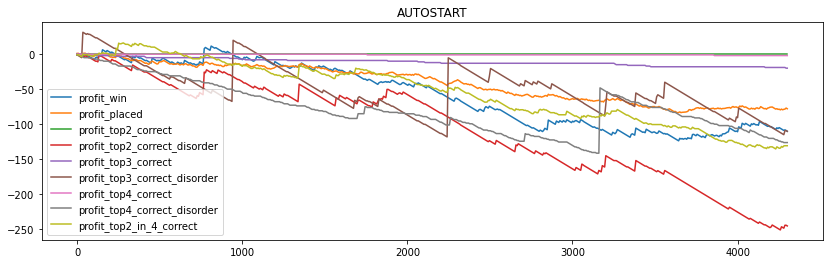

three_underdogs


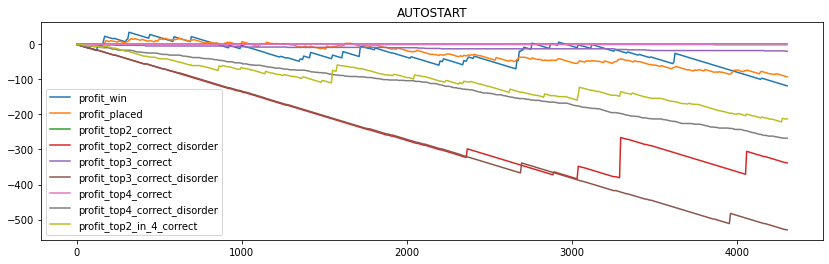

one_underdog_two_favs


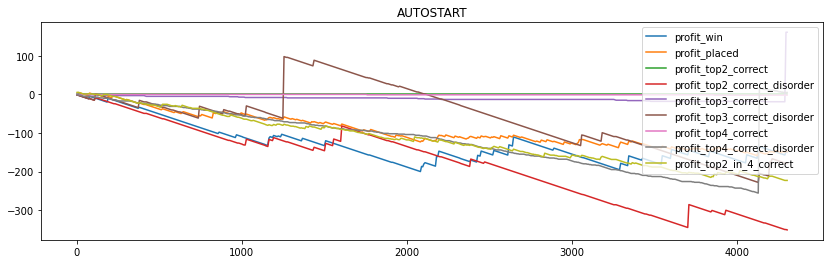

one_fav_two_underdogs


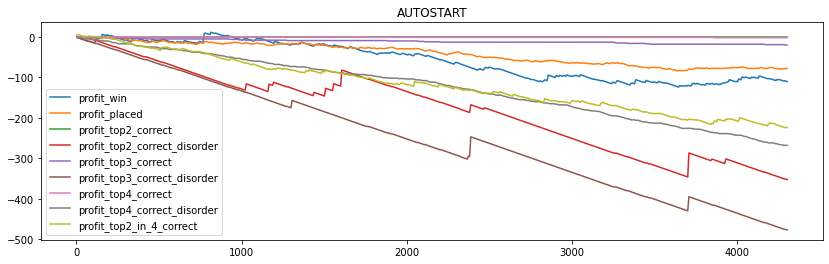

three_odds_favs


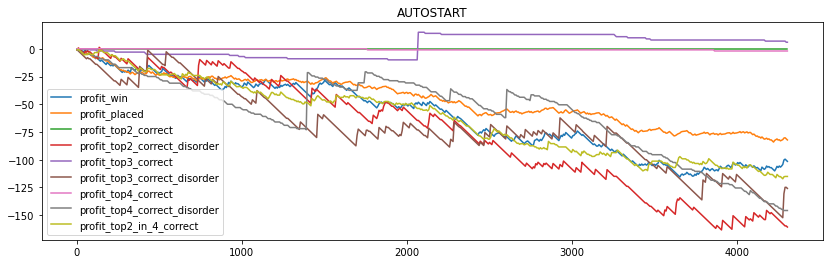

two_odds_fav_one_fav


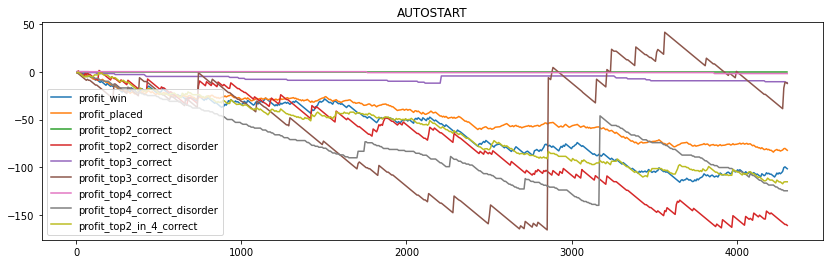

one_odds_fav_two_favs


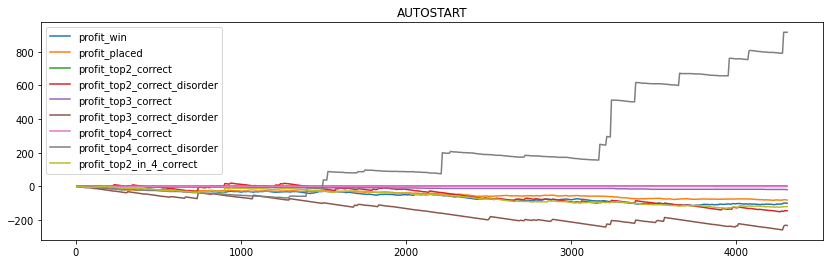

NATIONALE
three_favs


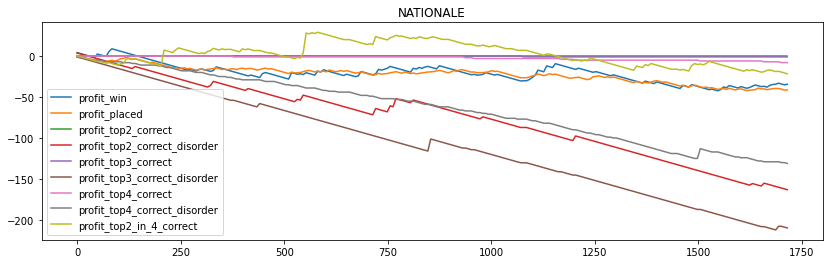

three_underdogs


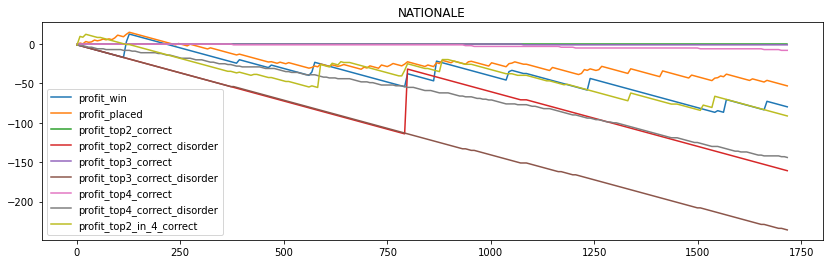

one_underdog_two_favs


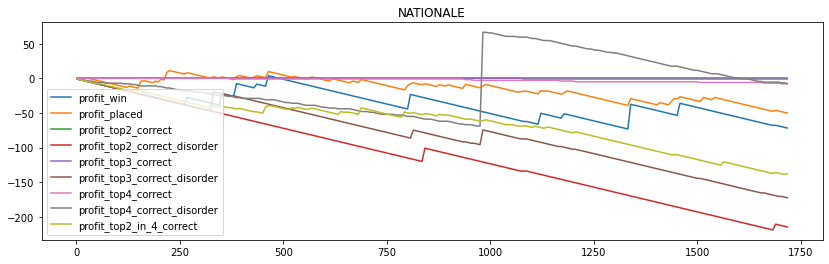

one_fav_two_underdogs


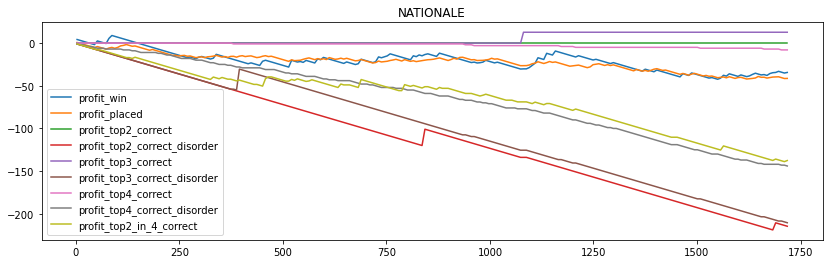

three_odds_favs


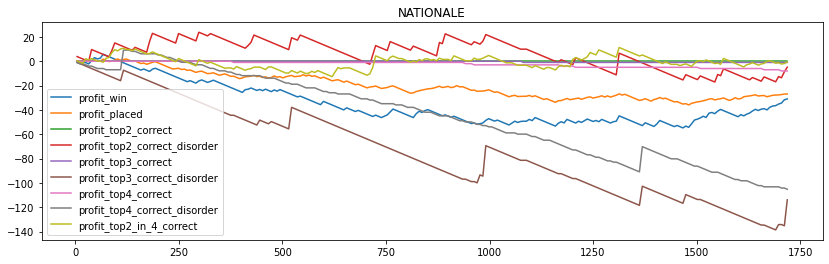

two_odds_fav_one_fav


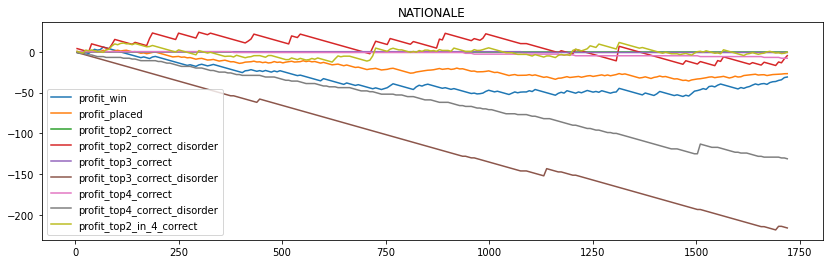

one_odds_fav_two_favs


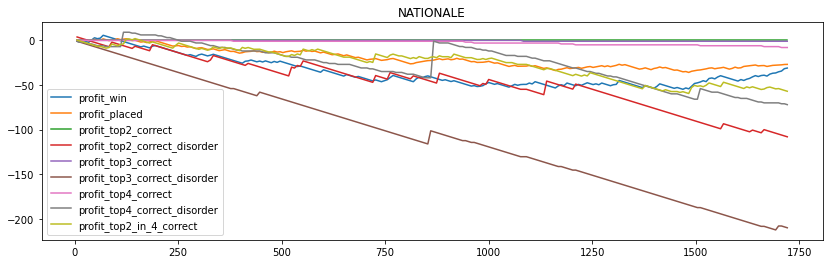

In [501]:
from matplotlib import pyplot as plt
for subcat in balphagore.bets.sub_category.value_counts().index[:5]:
    print(subcat)
    b = balphagore.bets
    b = b[(b['sub_category']==subcat) & (b['pred'] > 0) & (b['odds_1']>5)].copy()
    b.reset_index(inplace=True, drop=True)
    for strat in balphagore.strategies:
        print(strat["name"])
        for col in profit_cols:
            b[b['strategy']==strat["name"]][col].cumsum().plot(title=subcat, legend=True, figsize=(14,4))
        plt.show()

profit_win                     -0.135882
profit_placed                  -0.101176
profit_top2_correct             0.000000
profit_top2_correct_disorder   -0.502437
profit_top3_correct            -0.039496
profit_top3_correct_disorder   -0.216639
profit_top4_correct            -0.002521
profit_top4_correct_disorder    1.596134
profit_top2_in_4_correct       -0.291261
dtype: float64

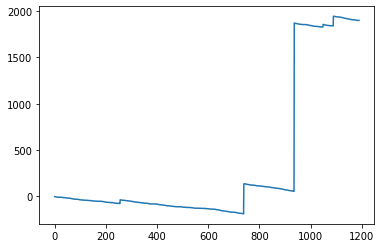

In [438]:
subcat = 'AUTOSTART'
col = 'profit_top4_correct_disorder'
strat = 0

b = balphagore.bets
b = b[(b['sub_category']==subcat) & (b['strategy']==strat+1) & (b['pred'] > 0)].copy()
b.reset_index(inplace=True, drop=True)
b[col].cumsum().plot()
b[profit_cols].mean()

profit_win                     -0.020000
profit_placed                  -0.030588
profit_top2_correct             0.000000
profit_top2_correct_disorder   -0.031176
profit_top3_correct             0.018235
profit_top3_correct_disorder    5.084706
profit_top4_correct            -0.005882
profit_top4_correct_disorder   -0.182353
profit_top2_in_4_correct        0.022353
dtype: float64

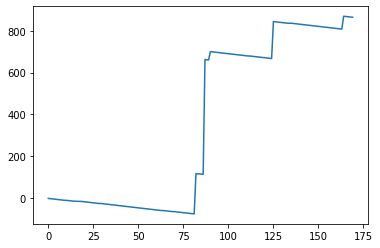

In [256]:
subcat = 'AUTOSTART'
col = 'profit_top3_correct_disorder'
strat = 7

b = balphagore.bets
b = b[(b['sub_category']==subcat) & (b['b_odds_mean3'] < 20) & (b['b_odds_mean3'] > b['b_odds_mean2']) & ((b['strategy']==strat+1)) & (b['declared_player_count']<20)].copy()
b.reset_index(inplace=True, drop=True)
b[col].cumsum().plot()
b[profit_cols].mean()

profit_win                      0.221811
profit_placed                   0.233333
profit_top2_correct             0.000000
profit_top2_correct_disorder   -1.000000
profit_top3_correct             0.000000
profit_top3_correct_disorder   -0.954733
profit_top4_correct            -0.045267
profit_top4_correct_disorder   -0.337449
profit_top2_in_4_correct       -0.399177
dtype: float64

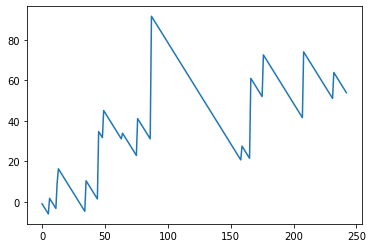

In [291]:
subcat = 'HANDICAP'
col = 'profit_win'
strat = 7

b = balphagore.bets
b = b[(b['sub_category']==subcat) & (b['b_odds_mean3'] > 20) & ((b['strategy']==strat+1))].copy()
b.reset_index(inplace=True, drop=True)
b[col].cumsum().plot()
b[profit_cols].mean()

In [439]:
cols = ['profit_top4_correct_disorder']
b[b['profit_top4_correct_disorder']>0][['race_id', 'start_at', 'b_odds_mean3', 'b_odds_1', 'b_odds_2', 'b_odds_3', 'odds_1', 'odds_2', 'odds_3', 'combo', 'combo_real', 'odds'] + cols]

,race_id,start_at,b_odds_mean3,b_odds_1,b_odds_2,b_odds_3,odds_1,odds_2,odds_3,combo,combo_real,odds,profit_top4_correct_disorder
256,79545,2019-05-31 15:15:00,12.366667,2.2,4.9,30.0,4.9,8.8,9.7,"[4, 2, 3, 7]","[4, 7, 3]","[2.2, 4.9, 30.0, 9.7]",41.0
739,83500,2019-09-11 19:40:00,30.366667,1.1,37.0,53.0,29.0,33.0,35.0,"[3, 1, 16, 12]","[3, 1, 12]","[1.1, 37.0, 53.0, 35.0]",324.5
936,85202,2019-10-28 17:02:00,20.666667,17.0,19.0,26.0,3.3,8.7,17.0,"[7, 2, 1, 9]","[1, 2, 9]","[17.0, 19.0, 26.0, 43.0]",1815.5
1049,86276,2019-11-26 17:02:00,11.000000,10.0,11.0,12.0,10.0,10.0,11.0,"[5, 3, 2, 4]","[4, 2, 3]","[10.0, 11.0, 12.0, 2.3]",27.4
1089,86771,2019-12-10 12:42:00,6.366667,7.7,1.4,10.0,7.7,10.0,24.0,"[5, 6, 2, 4]","[5, 6, 2]","[7.7, 1.4, 10.0, 63.0]",104.0


In [237]:
np.std([5.5,19.0,5.7])


6.317348248188387

In [234]:
b[profit_cols].mean()

profit_win                     -0.240000
profit_placed                   0.057846
profit_top2_correct             0.000000
profit_top2_correct_disorder   -0.329231
profit_top3_correct            -0.085846
profit_top3_correct_disorder    3.377846
profit_top4_correct             0.000000
profit_top4_correct_disorder    0.000000
profit_top2_in_4_correct       -0.065846
dtype: float64

In [199]:
b['b_odds_1']

0      15.0
1      17.5
2      12.2
3      14.8
4      23.8
       ... 
645    23.0
646    22.0
647    17.0
648    42.0
649     9.4
Name: b_odds_1, Length: 650, dtype: float64

In [195]:
b['odds_1']

0      5.8
1      5.8
2      5.9
3      6.8
4      4.4
      ... 
645    3.6
646    8.3
647    3.6
648    4.2
649    5.8
Name: odds_1, Length: 650, dtype: float64

In [ ]:
balphagore.save_model()

In [260]:
reco_mysql()
balphagore2 = Balphagore()
balphagore2.load_dataset(filters={'start_at__date__gte':'2021-09-01', 'start_at__date__lte':'2021-10-01'})

1281 races


In [ ]:
balphagore2.load_model()


In [261]:
balphagore2.models = balphagore.models

In [262]:
balphagore2.predict(balphagore2.df)

454/454 [==============================] - 2s 4ms/step


In [263]:
balphagore2.debug_race()

position         sub_category  num                   music  \
race_id id                                                                    
111020  1348111       2.0            NATIONALE    8  0a0aDaDa(20)3a4aDa0a2a   
        1348107       NaN            NATIONALE    4    Da2aDa2a2a6a5aDa5a9a   
        1348106      10.0            NATIONALE    3      9a7a1a1a2a8aRa7aDa   
        1348105       6.0            NATIONALE    2    6a6a0aDaDa2a1a2aDa4a   
        1348104      12.0            NATIONALE    1    DaDa0a1a3aDa5a4a2aDa   
        1348110       8.0            NATIONALE    7          Da4a2a3a2a2a1a   
        1348112      11.0            NATIONALE    9            3a1aDa1a2a2a   
        1348113       9.0            NATIONALE   10        6a2aDa7a1a2a4a1a   
        1348114       5.0            NATIONALE   11    1a4a7a3a7a0a4a8a5a4a   
        1348115       NaN            NATIONALE   12  3a3a1a1a2a3a3a(20)3a9a   
        1348116       NaN            NATIONALE   13    Da4a1a6aDa3aDa7a2a7a   
        1348117       NaN            NATIONALE   14  6m6m2m(20)1mDm4m3m5m6a   
        1348118       4.0            NATIONALE   15    DaDaDa3a6a4a5aDa2a6a   
        1348119       1.0            NATIONALE   16    0a2a2a1a4a4a4a3a4a8a   
        1348108       7.0            NATIONALE    5  5a1aDaDa9a2a8a5a(20)9a   
        1348109       3.0            NATIONALE    6    3a0a5aDa0a3aDa3a4a3a   
111504  1353521      14.0              INCONNU    3  0aDa6a0a(20)5a5a7a3a8a   
        1353520       1.0              INCONNU    2  5a7a0a3a2a1a5a2a(20)9a   
        1353519       NaN              INCONNU    1    1a1a1a9a9aDaDaDaDa6a   
        1353535       2.0              INCONNU   17  6a1a2a1aDa2a1a2a(20)Da   
        1353536      10.0              INCONNU   18  2a9a0a5a3a6a0a8a(20)6a   
        1353533       4.0              INCONNU   15    4a2a4mDa1a5a2a5a3a4a   
        1353522      12.0              INCONNU    4    8a4a7a3a3a8a4aDa5a5a   
        1353532      13.0              INCONNU   14  9a9a3a2a1a7a(20)9a2a6a   
        1353531       6.0              INCONNU   13  7a3a2a2a2a0a1a(20)5a3a   
        1353529       7.0              INCONNU   11  1a3a8a4a1a3a4a4a(20)8a   
        1353528       9.0              INCONNU   10              1a2a1aDa1a   
        1353530       8.0              INCONNU   12    5a3a5a4a1a6a5a5a1a5a   
        1353526      16.0              INCONNU    8    0aDa7a7aDaDa3a0aDaDa   
        1353525       5.0              INCONNU    7  4a2a5a5a2a7a5a0a(20)5a   
        1353524      15.0              INCONNU    6    1a7m5aDa8a5aDaDa1aDm   
        1353523       3.0              INCONNU    5    6a8a7a6m2mDa5a5a3aDa   
        1353527      11.0              INCONNU    9    4aDa4aDaDaDa0a9a1a2a   
        1353534       NaN              INCONNU   16    9a2a2a3aDa1a3a2a7a7a   
111505  1353543       5.0            NATIONALE    7    DaDa3a3a3aDa4a6a6a3a   
        1353546      12.0            NATIONALE   10    5a7a5a0a0a7a3a5aDa1a   
        1353545      11.0            NATIONALE    9    2a2a8aRa(19)0a8a2a1a   
        1353544       8.0            NATIONALE    8    0a5a9aDa7a7a2aDa0a9a   
        1353547       NaN            NATIONALE   11    4a4a5a3a9a2a0a0a2a3a   
        1353541       NaN            NATIONALE    5    0aTaDm2a3a9a1aDa0a3a   
        1353540       6.0            NATIONALE    4  Aa2a2a3a7a8a4a(20)0a4a   
        1353539       7.0            NATIONALE    3    4aDa7a6aDa4a0a5a6a0a   
        1353542       4.0            NATIONALE    6    DaDa4aDa8a2aDaDa6a1a   
        1353548       3.0            NATIONALE   12  Da3a5a0a(20)5a9aDa0a4a   
        1353554       NaN            NATIONALE   18    Da4aDa7aDa1a1a0a8a7a   
        1353550       1.0            NATIONALE   14    1a1a3aDa1a2a3a3a4a4a   
        1353538       NaN            NATIONALE    2  Da7aDaDaDa(20)Da1a2a5a   
        1353549      10.0            NATIONALE   13    1a3a7a8a7a5a9a1aDa1a   
        1353552       9.0            NATIONALE   16    Da6aDaDa7a6a

In [264]:
balphagore2.bet(balphagore2.df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1281/1281 [01:59<00:00, 10.76it/s]


In [265]:
balphagore2.compute_profit()

  0%|                                                                                                                                                         | 7/9880 [00:00<10:19, 15.93it/s]/opt/pysetup/.venv/lib/python3.7/site-packages/numpy/core/numeric.py:2378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
 11%|█████████████████                                                                                                                                     | 1120/9880 [00:14<01:43, 84.81it/s]

4 [5]
5 [5]
2 [5]
4 [4]
5 [4]
2 [4]
4 [1]
5 [1]
2 [1]
4 [3]
5 [3]
2 [3]
4 [7]
5 [7]
2 [7]
4 [8]
5 [8]
2 [8]
4 [6]
5 [6]
2 [6]
4 [2]
5 [2]
2 [2]


 33%|██████████████████████████████████████████████████                                                                                                    | 3301/9880 [00:41<01:20, 81.97it/s]

6-4 [6, 3, 8]
6-3 [6, 3, 8]
6-1 [6, 3, 8]
4-3 [6, 3, 8]
4-1 [6, 3, 8]
3-1 [6, 3, 8]
4 [6]
6 [6]
3 [6]
6-4 [3, 8, 5]
6-3 [3, 8, 5]
6-1 [3, 8, 5]
4-3 [3, 8, 5]
4-1 [3, 8, 5]
3-1 [3, 8, 5]
4 [3]
6 [3]
3 [3]
6-4 [8, 5, 4]
6-3 [8, 5, 4]
6-1 [8, 5, 4]
4-3 [8, 5, 4]
4-1 [8, 5, 4]
3-1 [8, 5, 4]
4 [8]
6 [8]
3 [8]
6-4 [5, 4, 1]
6-3 [5, 4, 1]
6-1 [5, 4, 1]
4-3 [5, 4, 1]
4-1 [5, 4, 1]
3-1 [5, 4, 1]
4 [5]
6 [5]
3 [5]
6-4 [2, 10, 9]
6-3 [2, 10, 9]
6-1 [2, 10, 9]
4-3 [2, 10, 9]
4-1 [2, 10, 9]
3-1 [2, 10, 9]
4 [2]
6 [2]
3 [2]
6-4 [10, 9, 7]
6-3 [10, 9, 7]
6-1 [10, 9, 7]
4-3 [10, 9, 7]
4-1 [10, 9, 7]
3-1 [10, 9, 7]
4 [10]
6 [10]
3 [10]
6-4 [9, 7, 1]
6-3 [9, 7, 1]
6-1 [9, 7, 1]
4-3 [9, 7, 1]
4-1 [9, 7, 1]
3-1 [9, 7, 1]
4 [9]
6 [9]
3 [9]
6-4 [7, 1, 4]
6-3 [7, 1, 4]
6-1 [7, 1, 4]
4-3 [7, 1, 4]
4-1 [7, 1, 4]
3-1 [7, 1, 4]
4 [7]
6 [7]
3 [7]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9880/9880 [02:11<00:00, 75.29it/s]


In [266]:
b = balphagore2.bets

In [267]:
b.filter(regex='^top', axis=1).describe()

,top1_correct,top1_in_3_correct,top2_correct,top2_correct_disorder,top3_correct,top3_correct_disorder,top4_correct,top4_correct_disorder,top2_in_4_correct
count,9880.000000,9880.000000,9880.000000,9880.000000,9880.000000,9880.000000,9880.000000,9880.000000,9880.000000
mean,0.100810,0.294028,0.014575,0.026923,0.002632,0.014980,0.000607,0.012652,0.137854
std,0.301092,0.455628,0.119850,0.161867,0.051234,0.121478,0.024637,0.111772,0.344764
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
b.filter(regex='^profit_', axis=1).describe()

profit_win                     -0.652778
profit_placed                  -0.424306
profit_top2_correct             0.000000
profit_top2_correct_disorder   -0.833333
profit_top3_correct            -0.152778
profit_top3_correct_disorder   -0.833333
profit_top4_correct             0.000000
profit_top4_correct_disorder    0.000000
profit_top2_in_4_correct        0.036111
dtype: float64

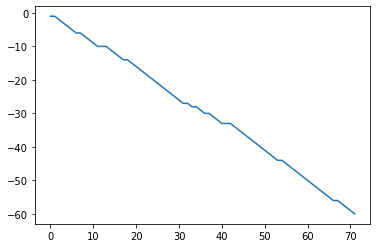

In [270]:
subcat = 'AUTOSTART'
col = 'profit_top3_correct_disorder'
strat = 7

b = balphagore2.bets
b = b[(b['sub_category']==subcat) & (b['final_odds'] < 30) & ((b['strategy']==strat+1)) & (b['declared_player_count']<14)].copy()
b.reset_index(inplace=True, drop=True)
b[col].cumsum().plot()
b[profit_cols].mean()

profit_win                      2.692308
profit_placed                   0.200000
profit_top2_correct             0.000000
profit_top2_correct_disorder   -1.000000
profit_top3_correct             0.000000
profit_top3_correct_disorder   -0.846154
profit_top4_correct            -0.153846
profit_top4_correct_disorder   -0.384615
profit_top2_in_4_correct       -0.615385
dtype: float64

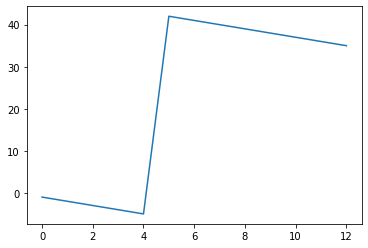

In [314]:
subcat = 'HANDICAP'
col = 'profit_win'
strat = 7

b = balphagore2.bets
b = b[(b['sub_category']==subcat) & (b['b_odds_1'] > 30) & ((b['strategy']==strat+1))].copy()
b.reset_index(inplace=True, drop=True)
b[col].cumsum().plot()
b[profit_cols].mean()

In [316]:
(1/30) * 14

0.4666666666666667